In [ ]:
#Installing Necessary Packages
# !pip install imblearn
# !pip install --upgrade imblearn
%matplotlib inline
!pip show scikit-learn
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, precision_recall_curve

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from lime import lime_tabular
%matplotlib inline

from statsmodels.genmod import families
from statsmodels.formula.api import glm

sns.set(style="white")

Name: scikit-learn
Version: 1.3.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: C:\Users\haile\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: imbalanced-learn, interpret-core, lime, shap


In [ ]:
#Accessing Dataset
df = pd.read_csv("C:/Users/haile/OneDrive/Documents/TelcoCustomerChurn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2285.169963
std,0.368612,24.559481,30.090047,2267.544511
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.675000
50%,0.000000,29.000000,70.350000,1398.250000
75%,0.000000,55.000000,89.850000,3803.050000
max,1.000000,72.000000,118.750000,8684.800000


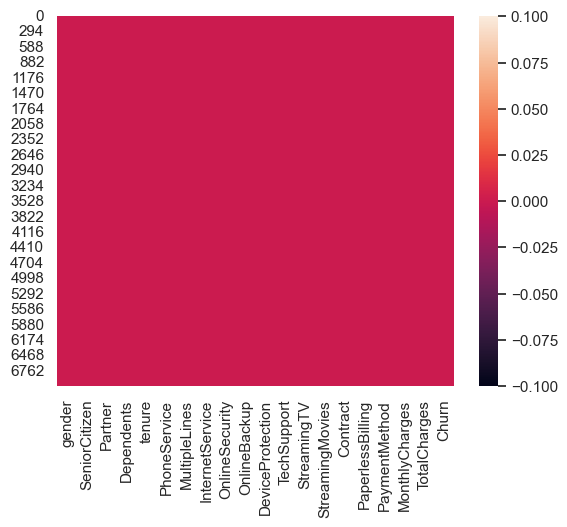

In [ ]:
#Data Cleaning
#Convert string variables to floats
l1 = [len(i.split()) for i in df['TotalCharges']]
l2 = [i for i in range(len(l1)) if l1[i] != 1]

for i in l2:
    df.loc[i,'TotalCharges'] = df.loc[(i-1),'TotalCharges']

df['TotalCharges'] = df['TotalCharges'].astype(float)
df.drop(columns = ['customerID'], inplace = True)

#Check for null values
sns.heatmap(df.isnull())
df.describe()

In [ ]:
#Data Preparation & Pre-Processing
#Label Encoder
label_encoder = LabelEncoder()
df_cg = df.copy(deep=True)

text_data_features = [i for i in list(df.columns) if i not in list(df.describe().columns)]

for col in text_data_features:
  df_cg[col] = label_encoder.fit_transform(df_cg[col])

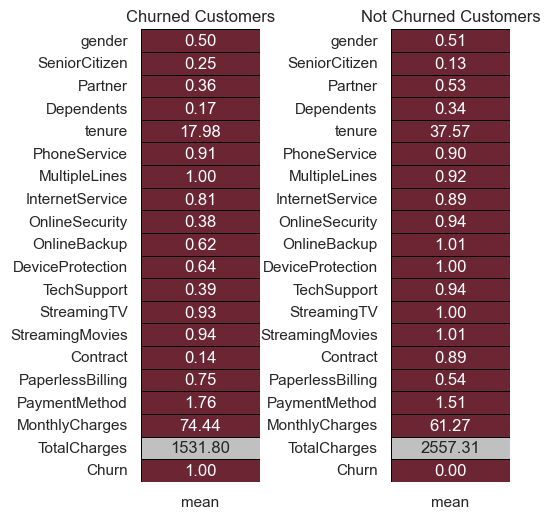

In [ ]:
#Exploratory Data Analysis
#Mean Feature Values by Churn/No Churn
colors = ['#6C2633','#C0C0C0']

churn = df_cg[df_cg['Churn'] == 1].describe().T
no_churn = df_cg[df_cg['Churn'] == 0].describe().T

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (5,5))
plt.subplot(1,2,1)
sns.heatmap(churn[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('Churned Customers');

plt.subplot(1,2,2)
sns.heatmap(no_churn[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f',)
plt.title('Not Churned Customers');

fig.tight_layout(pad = 0)

In [ ]:
#Splitting the categorical & numerical variables
df['SeniorCitizen'] = df['SeniorCitizen'].astype("object")
# df.info()
categorical_features = []
numerical_features = []
col = list(df_cg.columns)
for column in col:
    if len(df[column].unique()) > 6:
        numerical_features.append(column)
    else:
        categorical_features.append(column)
print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : gender SeniorCitizen Partner Dependents PhoneService MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies Contract PaperlessBilling PaymentMethod Churn
Numerical Features : tenure MonthlyCharges TotalCharges


C:\Users\haile\AppData\Local\Temp\ipykernel_4572\1088742119.py:12: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(wedges, labels=['Not-Churn Customer', 'Churn Customer'], labelcolor='black', loc='lower right')


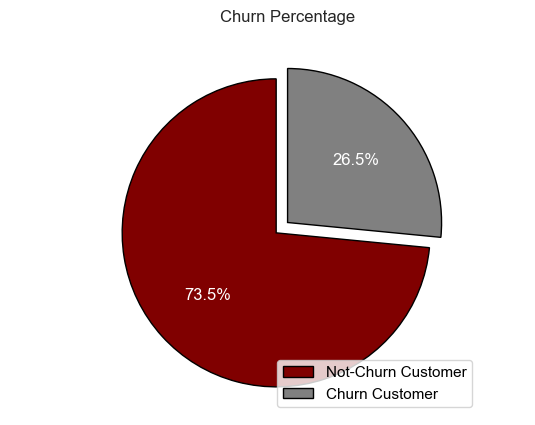

In [ ]:
# Calculate churn percentages
churn_counts = df_cg['Churn'].value_counts()
churn_percentages = (churn_counts / churn_counts.sum()) * 100
colors=['maroon','grey']

# Create the pie chart
plt.figure(figsize=(10, 5))
wedges, texts, autotexts = plt.pie(churn_percentages, labels=['Not-Churn Customer', 'Churn Customer'], autopct='%1.1f%%', startangle=90, explode=(0.1, 0), colors=colors,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True},
        textprops={'color': 'white'})

plt.legend(wedges, labels=['Not-Churn Customer', 'Churn Customer'], labelcolor='black', loc='lower right')

# Add title and show the plot
plt.title('Churn Percentage')
plt.show()

In [ ]:
#Examining Relationship Between Churn & Categorical Variables
categorical_features.remove('Churn')
customer_info = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
device_services = ['PhoneService', 'MultipleLines', 'InternetService', 'StreamingTV', 'StreamingMovies']
support_services = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport']
payment = ['Contract','PaperlessBilling','PaymentMethod']

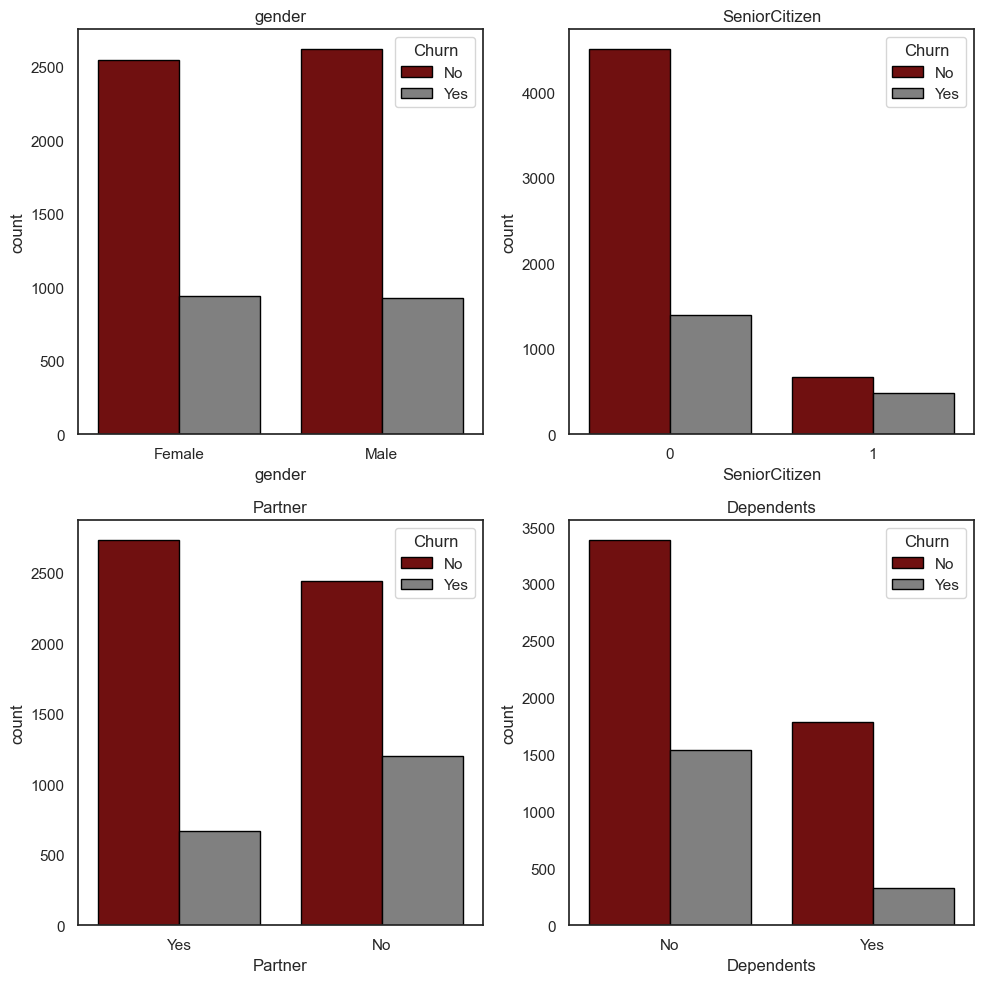

In [ ]:
#Customer Information
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, column in enumerate(customer_info):
    ax = axes[i // 2, i % 2]
    sns.countplot(x=customer_info[i], hue="Churn", data=df, palette=colors, edgecolor='black', ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

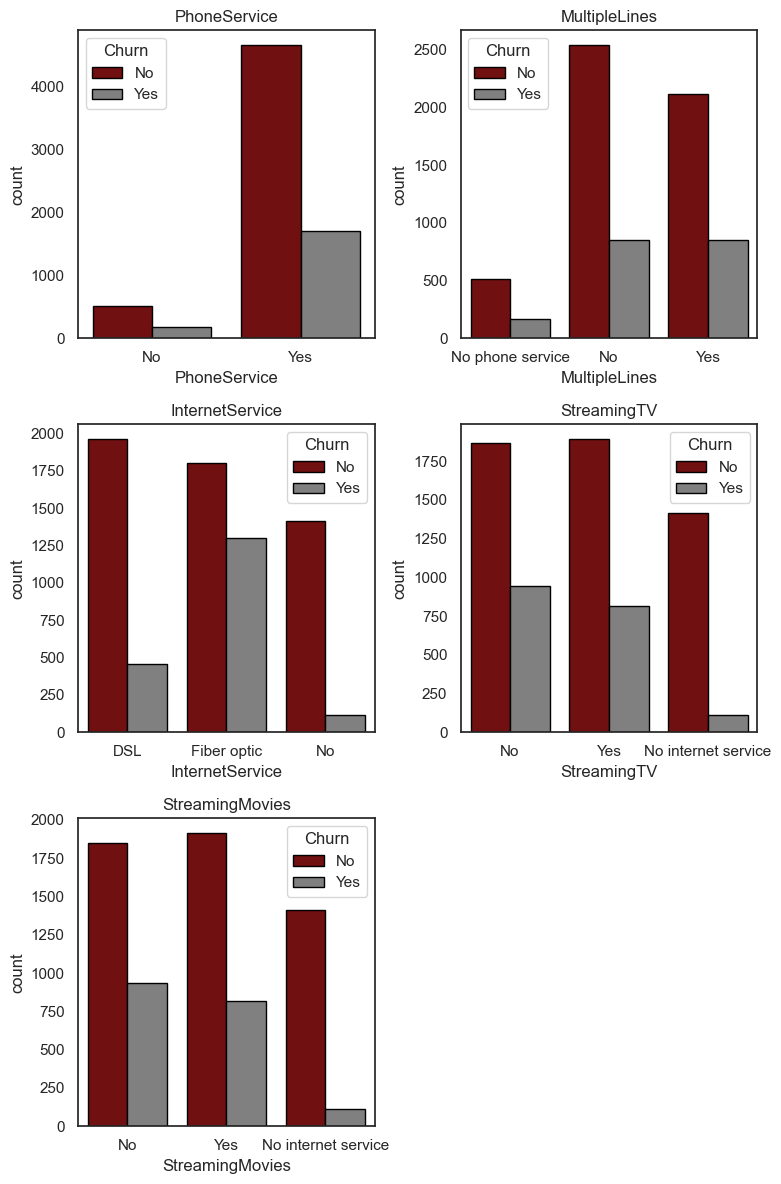

In [ ]:
#Device Services
fig, axes = plt.subplots(3, 2, figsize=(8, 12))

for i in range(5):
    ax = axes[i // 2, i % 2]
    sns.countplot(x=device_services[i], hue="Churn", data=df, palette=colors, edgecolor='black', ax=ax)
    ax.set_title(device_services[i])

axes[2,1].set_visible(False)

plt.tight_layout()
plt.show()

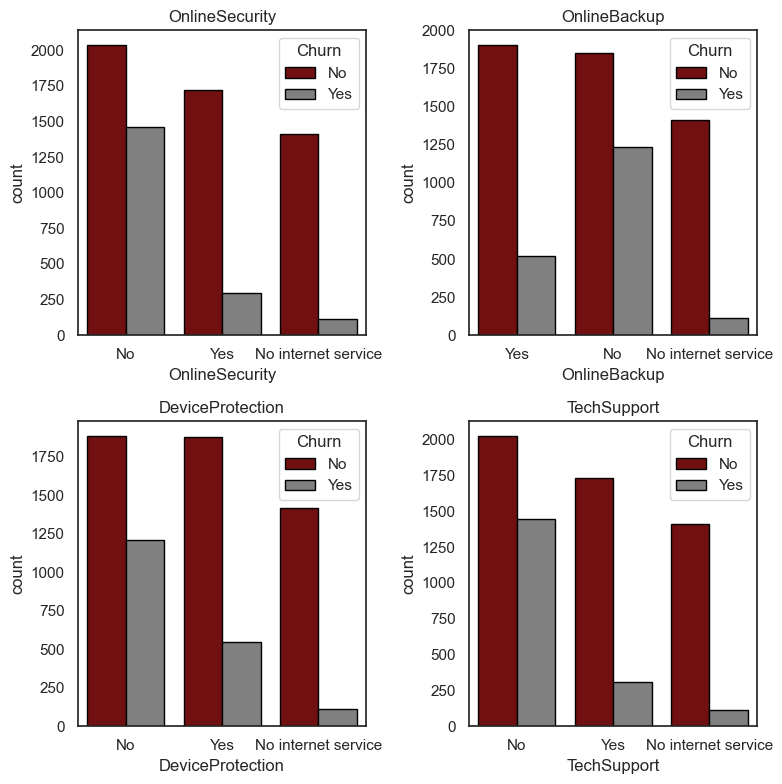

In [ ]:
#Support Services
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i in range(4):
    ax = axes[i // 2, i % 2]
    sns.countplot(x=support_services[i], hue="Churn", data=df, palette=colors, edgecolor='black', ax=ax)
    ax.set_title(support_services[i])

plt.tight_layout()
plt.show()

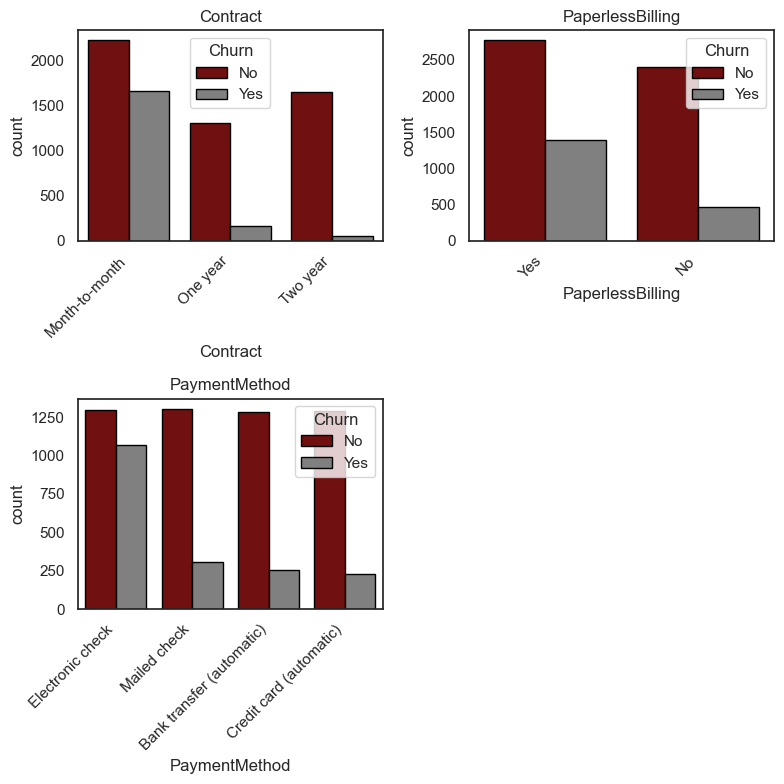

In [ ]:
#Payment Type
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i in range(3):
    ax = axes[i // 2, i % 2]
    sns.countplot(x=payment[i], hue="Churn", data=df, palette=colors, edgecolor='black', ax=ax)
    ax.set_title(payment[i])
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

axes[1,1].set_visible(False)

plt.tight_layout()
plt.show()

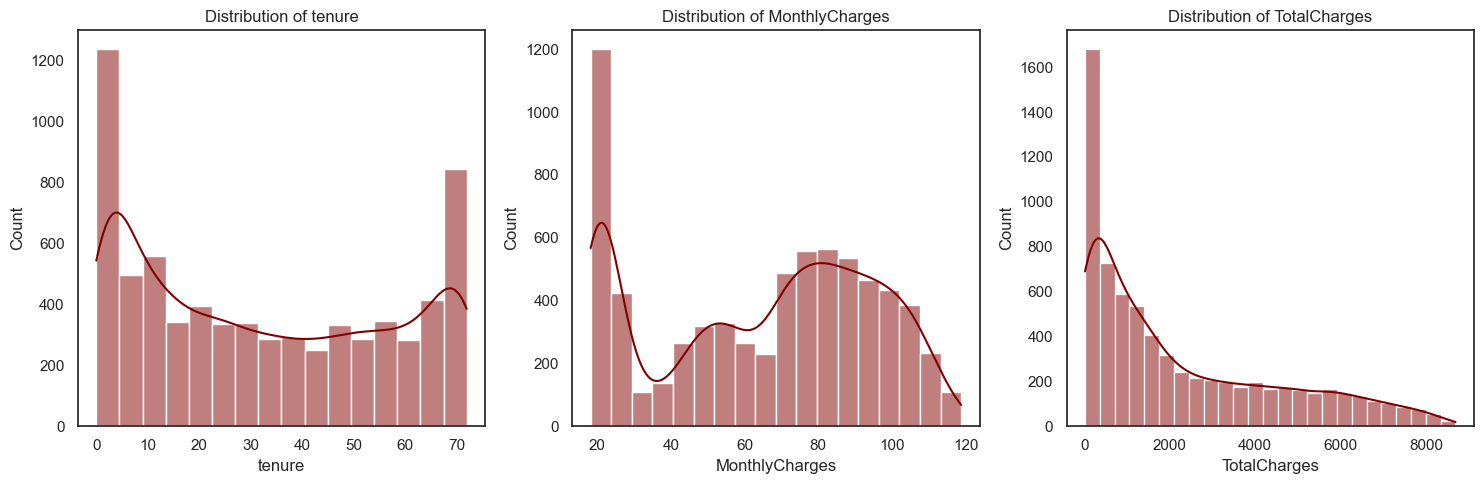

In [ ]:
#Examining Relationship Between Churn & Numerical Variables
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, feature in enumerate(numerical_features):
    ax = axes[i]
    sns.histplot(data=df_cg, x=feature, color=colors[0], kde=True, ax=ax)
    ax.set_title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()

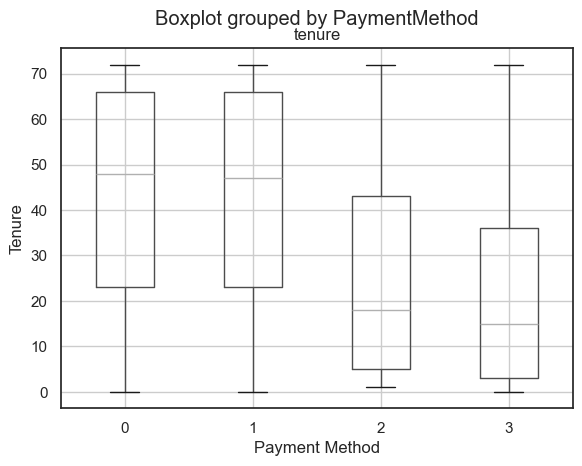

In [ ]:
#Tenure by Payment Method
df_cg.boxplot('tenure', by='PaymentMethod')
plt.xlabel('Payment Method')
_ = plt.ylabel('Tenure')

<Axes: xlabel='tenure', ylabel='MonthlyCharges'>

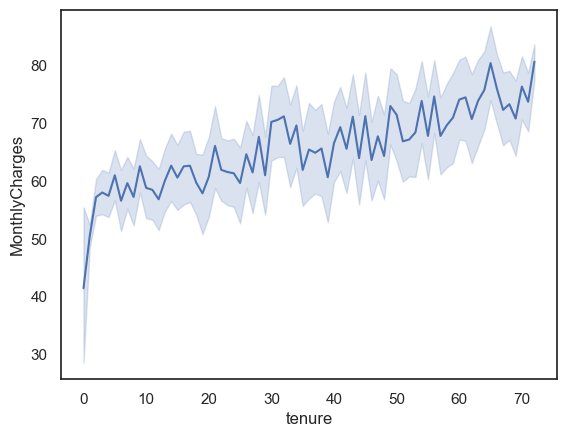

In [ ]:
#Monthly Charge by Tenure
sns.lineplot(data=df_cg, x="tenure", y="MonthlyCharges")

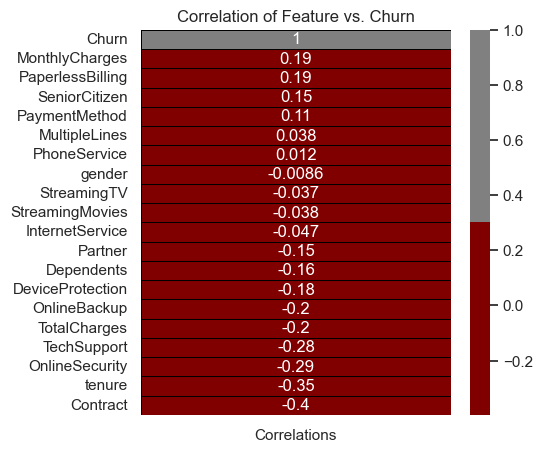

In [ ]:
#Feature Engineering
#Correlation of Feature vs. Churn
corr = df_cg.corrwith(df_cg['Churn']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation of Feature vs. Churn');

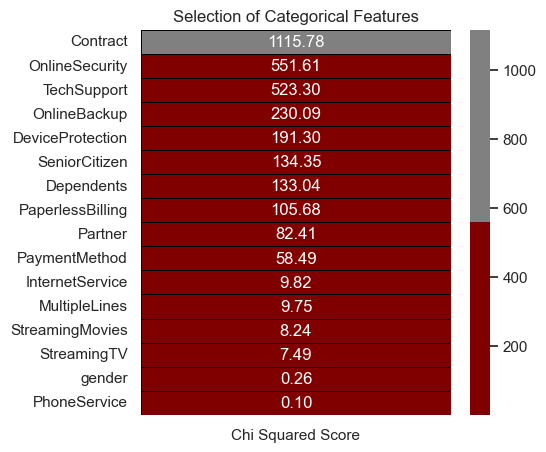

In [ ]:
#Selecting Relevant Categorical Variables
features = df_cg.loc[:,categorical_features]
target = df_cg.loc[:,'Churn']

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score'])

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features');

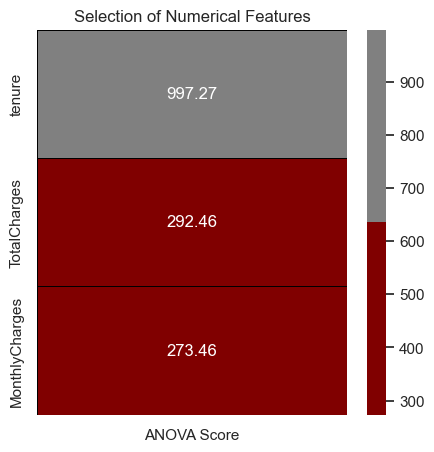

In [ ]:
#Selecting Relevant Numerical Variables
features = df_cg.loc[:,numerical_features]
target = df_cg.loc[:,'Churn']

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score'])

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

In [ ]:
#Drop variables with correlation against churn < 0.1 & > -0.1 and/or low relation with Churn based on chi-squared score
df_cg.drop(columns = ['MultipleLines', 'PhoneService','gender','StreamingTV','StreamingMovies','InternetService'],inplace = True)
df_cg.drop(columns = ['TotalCharges'],inplace = True)
df_cg.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,0,1,0,1,0,2,0,0,0,1,2,29.85,0
1,0,0,0,34,2,0,2,0,1,0,3,56.95,0
2,0,0,0,2,2,2,0,0,0,1,3,53.85,1
3,0,0,0,45,2,0,2,2,1,0,0,42.30,0
4,0,0,0,2,0,0,0,0,0,1,2,70.70,1


K MEANS CLUSTERING

C:\Users\haile\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\haile\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\haile\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\haile\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\clus

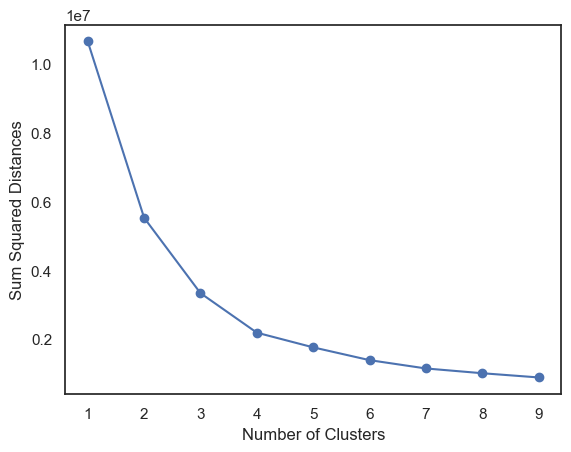

[[6.04288499e-02 5.22417154e-01 4.56140351e-01 3.40116959e+01
  9.62962963e-01 9.27875244e-01 9.31773879e-01 9.78557505e-01
  1.14035088e+00 3.27485380e-01 1.69395712e+00 2.38452242e+01
  4.48343080e-02]
 [2.30237154e-01 7.24308300e-01 3.10276680e-01 6.30770751e+01
  1.07707510e+00 1.51778656e+00 1.48616601e+00 1.13043478e+00
  1.23418972e+00 7.45059289e-01 1.12351779e+00 1.02515958e+02
  1.62055336e-01]
 [2.40219092e-01 2.88732394e-01 1.54929577e-01 7.63380282e+00
  2.78560250e-01 4.30359937e-01 4.74178404e-01 2.80125196e-01
  4.61658842e-02 7.63693271e-01 1.79733959e+00 8.13730829e+01
  6.18153365e-01]
 [1.37884873e-01 7.10843373e-01 4.17670683e-01 6.22838019e+01
  1.27978581e+00 1.25568942e+00 1.25568942e+00 1.25033467e+00
  1.41767068e+00 5.78313253e-01 1.01338688e+00 7.18617805e+01
  6.02409639e-02]
 [4.66200466e-02 3.07692308e-01 3.14685315e-01 7.24825175e+00
  8.58974359e-01 8.77622378e-01 8.28671329e-01 8.68298368e-01
  3.82284382e-01 3.41491841e-01 2.23892774e+00 2.23279138e+0

In [ ]:
#Building the Model
#K-Means Clustering
k_values=range(1,10)
squared_values=[]
for k in k_values:
  kmeans=KMeans(n_clusters=k, random_state=42)
  kmeans.fit(df_cg)
  squared_values.append(kmeans.inertia_)

#Graph to find the elbow
plt.plot(k_values,squared_values,marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum Squared Distances')
plt.show()

#Add column to dataset
cluster_labels=kmeans.labels_
df_cg['Cluster']=cluster_labels
print(kmeans.cluster_centers_)

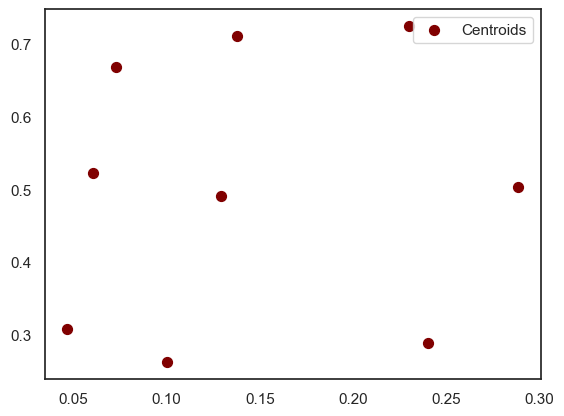

In [ ]:
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='maroon', marker='o', label='Centroids')
plt.legend()

LOGISTIC REGRESSION

In [ ]:
#Splitting the train and test data
X=df_cg.drop('Churn', axis=1)
y=df_cg['Churn']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [ ]:
#Scaling the Data
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [ ]:
sample=SMOTE(random_state=42)
X_train_sample, y_train_sample=sample.fit_resample(X_train,y_train)

In [ ]:
def lr_model(classifier,x_train,y_train,x_test,y_test):

    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))

In [ ]:
#Logistic Regression Model
lgm_model=LogisticRegression()
lgm_model.fit(X_train_sample,y_train_sample)

C:\Users\haile\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
predict_logistic_test=lgm_model.predict(X_test_scaled)
predict_logistic_train = lgm_model.predict(X_train_scaled)

C:\Users\haile\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\haile\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [ ]:
print(lr_model(lgm_model,X_train,y_train,X_test,y_test))

C:\Users\haile\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\haile\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Cross Validation Score :  83.44%
None


C:\Users\haile\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
accuracy_logistic2 = accuracy_score(y_test, predict_logistic_test)
confusion_matrix_logistic2 = confusion_matrix(y_test, predict_logistic_test)
classification_logistic2 = classification_report(y_test, predict_logistic_test)
lr_roc_auc2 = roc_auc_score(y_test, predict_logistic_test)

Intercept and Coefficients: [-1.04713936] [[ 0.2180607   0.14214941 -0.19581751 -0.03026698 -0.31776749 -0.10879859
  -0.0133849  -0.25329934 -0.7938466   0.33110103  0.06280176  0.02189883
  -0.05304683]]

Accuracy is 0.6146202980837473

Confusion Matrix:



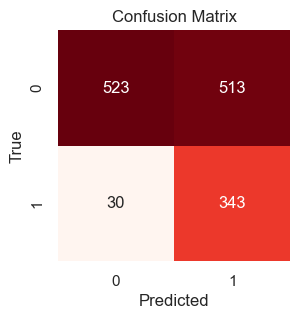


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.50      0.66      1036
           1       0.40      0.92      0.56       373

    accuracy                           0.61      1409
   macro avg       0.67      0.71      0.61      1409
weighted avg       0.80      0.61      0.63      1409


ROC AUC:
 0.7121986502013311


In [ ]:
print("Intercept and Coefficients:", lgm_model.intercept_, lgm_model.coef_)
print("\nAccuracy is", accuracy_logistic2)

print("\nConfusion Matrix:\n")
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix_logistic2, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n", classification_logistic2)

print("\nROC AUC:\n", lr_roc_auc2)

In [ ]:
lgm_model_2 = glm("y ~ X", data = df_cg, family=families.Binomial())
results = lgm_model_2.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 7043
Model:                            GLM   Df Residuals:                     7029
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2966.3
Date:                Tue, 05 Mar 2024   Deviance:                       5932.7
Time:                        19:52:13   Pearson chi2:                 7.16e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2701
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2293      0.145     -8.497      0.0

RANDOM FOREST

In [ ]:
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
df_cg['Cluster'] = kmeans.fit_predict(X)

C:\Users\haile\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
X['Cluster'] = df_cg['Cluster']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled_rf = scaler.fit_transform(X_train)
X_test_scaled_rf = scaler.transform(X_test)

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled_rf, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf_classifier.predict(X_test_scaled_rf)

In [ ]:
print(lr_model(rf_classifier,X_train,y_train,X_test,y_test))

Cross Validation Score :  81.20%
None


In [ ]:
accuracy_rf = accuracy_score(y_test, y_pred)
conf_matrix_rf = confusion_matrix(y_test, y_pred)
lr_roc_rf = roc_auc_score(y_test, predict_logistic_test)

Accuracy: 0.7934705464868701

Confusion Matrix:



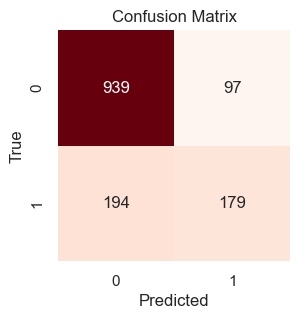


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.50      0.66      1036
           1       0.40      0.92      0.56       373

    accuracy                           0.61      1409
   macro avg       0.67      0.71      0.61      1409
weighted avg       0.80      0.61      0.63      1409

0.7121986502013311


In [ ]:
print(f'Accuracy: {accuracy_rf}')
print("\nConfusion Matrix:\n")
plt.figure(figsize=(3,3))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
classification_rf = classification_report(y_test, predict_logistic_test)
print("\nClassification Report:\n", classification_rf)
print(lr_roc_rf)

DECISION TREE MODELING

In [ ]:
dt_classifier=DecisionTreeClassifier(random_state=42)

In [ ]:
dt_classifier.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
y_pred_dt=dt_classifier.predict(X_test)

In [ ]:
print(lr_model(dt_classifier,X_train,y_train,X_test,y_test))

Cross Validation Score :  65.91%
None


In [ ]:
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
classification_dt = classification_report(y_test, y_pred_dt)
lr_roc_dt = roc_auc_score(y_test, predict_logistic_test)

In [ ]:
print(f'Accuracy: {accuracy_dt}')
print(f'Confusion Matrix:\n{conf_matrix_dt}')
print(f'Classification Report:\n{classification_dt}')
print(lr_roc_dt)

Accuracy: 0.7203690560681334
Confusion Matrix:
[[829 207]
 [187 186]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1036
           1       0.47      0.50      0.49       373

    accuracy                           0.72      1409
   macro avg       0.64      0.65      0.65      1409
weighted avg       0.73      0.72      0.72      1409

0.7121986502013311


XG BOOST 

In [ ]:
sample=SMOTE(random_state=42)
X_train_sample, y_train_sample=sample.fit_resample(X_train,y_train)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train_sample, y_train_sample, test_size=0.2, random_state=42)

In [ ]:
#def model(classifier,x_train,y_train,x_test,y_test):

    #classifier.fit(x_train,y_train)
    #prediction = classifier.predict(x_test)
    #cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    #print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    #print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    #plot_roc_curve(classifier, x_test,y_test)
    #plt.title('ROC_AUC_Plot')
    #plt.show()

In [ ]:
classifier_xgb = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)

In [ ]:
# Initial train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Applying SMOTE to training set only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Initialize XGBoost model
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=200)

# Train the model
xgb_model.fit(X_train_smote, y_train_smote)

# Evaluate the model on the original scaled test set
predictions = xgb_model.predict(X_test_scaled)

In [ ]:
lr_model(xgb_model,X_train,y_train,X_test,y_test)

Cross Validation Score :  83.12%


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification = classification_report(y_test, y_pred)

print(accuracy)
print(conf_matrix)
print(classification)

0.7934705464868701
[[939  97]
 [194 179]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.65      0.48      0.55       373

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



RANDOM FOREST WITH LIME

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
explainer_lime = lime_tabular.LimeTabularExplainer(X_train_scaled, feature_names=X_train.columns, class_names=df_cg['Churn'].unique(), discretize_continuous=True)

In [ ]:
sample_idx = 0
explanation = explainer_lime.explain_instance(X_test.values[sample_idx], rf_model.predict_proba, num_features=4)

In [ ]:
print("Actual class:", y_test.values[sample_idx])
print("Predicted class:", rf_model.predict([X_test.values[sample_idx]])[0])
explanation.show_in_notebook()

Actual class: 1
Predicted class: 0


In [ ]:
accuracy_lime=accuracy_score(y_test,predictions)
print(accuracy_lime)
recall_lime=recall_score(y_test,predictions)
print(recall_lime)
f1_lime=f1_score(y_test,predictions)
print(f1_lime)

0.7821149751596878
0.67828418230563
0.6223862238622386
